# Opportunity Youth in South King County updated with 2017 data

## Import Necessary Packages

In [241]:
from sqlalchemy import create_engine
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

## Load Data from postgresQL database into Pandas DataFrame

In [3]:
engine = create_engine("postgresql:///opportunity_youth")

The following query selects all columns from the `pums_2017` database filtered by rows that meet the qualifications for South King County opportunity youth (i.e., ages 16-24 and neither currently enrolled nor employed).

In [77]:
query = """SELECT * 
           FROM pums_2017 
           WHERE (rt = 'P') 
           AND (puma = '11604' OR puma = '11605' OR puma = '11610' OR puma = '11613' OR puma = '11614' OR puma = '11615' OR puma = '11611' OR puma = '11612') 
           AND (agep BETWEEN 16 AND 24) 
           AND (sch = '1') 
           AND (esr = '3' OR esr = '6')"""

In [78]:
opp_youth = pd.read_sql(sql = query, con = engine) #read table query into Pandas DataFrame

In [79]:
opp_youth.head()

,rt,serialno,division,sporder,puma,region,st,adjinc,pwgtp,agep,...,pwgtp71,pwgtp72,pwgtp73,pwgtp74,pwgtp75,pwgtp76,pwgtp77,pwgtp78,pwgtp79,pwgtp80
0,P,2013000008875,9,05,11604,4,53,1061971,36.0,19.0,...,41.0,47.0,8.0,44.0,56.0,25.0,11.0,12.0,34.0,66.0
1,P,2013000030421,9,02,11611,4,53,1061971,11.0,19.0,...,16.0,12.0,10.0,9.0,9.0,10.0,13.0,11.0,10.0,10.0
2,P,2013000047506,9,04,11615,4,53,1061971,5.0,20.0,...,1.0,6.0,6.0,7.0,5.0,2.0,4.0,1.0,6.0,1.0
3,P,2013000048962,9,05,11612,4,53,1061971,25.0,22.0,...,7.0,37.0,24.0,44.0,26.0,7.0,25.0,9.0,39.0,7.0
4,P,2013000057563,9,05,11611,4,53,1061971,20.0,21.0,...,6.0,7.0,24.0,23.0,6.0,33.0,19.0,33.0,33.0,18.0


## Estimating Opportunity Youth

The estimate of 2019 opportunity youth is calculated by summing all the records, but each record is multiplied by the column `pwgtp` which is the weight that record holds for the total population. Here, if we sum `pwgtp` across all the rows, we get an estimate of the opportunity youth in South King County.

In [80]:
opp_youth_est = opp_youth['pwgtp'].sum()
print(opp_youth_est)

12438.0


If we want to get the number of opportunity youth represented by each PUMA in South King County in the newest dataset, we can use the following:

In [104]:
OYbyPUMA = opp_youth.groupby('puma')['pwgtp'].sum()

In [105]:
OYbyPUMA

puma
11604     916.0
11605     908.0
11610    1853.0
11611    2038.0
11612    1977.0
11613    2006.0
11614    1530.0
11615    1210.0
Name: pwgtp, dtype: float64

## Calculating Opportunity Youth Status by Age

The 2016 report on opportunity youth contains a breakdown of opportunity youth and total youth by age, their education status, and their employment status. Here, we recalculate these statistics using the updated information.

The following SQL query retuns a table with an estimate and percentage of the youth population that is an opportunity youth, not an opportunity youth, and youths working without a diploma.

In [81]:
query_total_population = """SELECT age_flag, oy_flag, SUM(pwgtp) as estimate, SUM(SUM(pwgtp)) OVER(PARTITION BY age_flag) AS total, ROUND((SUM(pwgtp) / SUM(SUM(pwgtp)) OVER(PARTITION BY age_flag)) * 100, 2) AS percent
                         FROM (
                               SELECT CASE WHEN (sch = '1' AND (esr = '3' OR esr = '6')) THEN 'OY' 
                                           WHEN (sch = '1' AND (schl::INTEGER < 16) AND (esr = '1' OR esr = '2')) THEN 'Working without diploma'
                                           ELSE 'Not OY' 
                                           END AS oy_flag,
                                      CASE WHEN (agep BETWEEN 16 AND 18) THEN 'Age 16-18'
                                           WHEN (agep BETWEEN 19 AND 21) THEN 'Age 19-21'
                                           ELSE 'Age 22-24'
                                           END AS age_flag,
                                      pwgtp
                               FROM pums_2017
                               WHERE (rt = 'P')
                               AND (puma = '11604' OR puma = '11605' OR puma = '11610' OR puma = '11613' OR puma = '11614' OR puma = '11615' OR puma = '11611' OR puma = '11612') 
                               AND (agep BETWEEN 16 AND 24)
                               ) AS temp
                          GROUP BY age_flag, oy_flag"""

In [167]:
total_population = pd.read_sql(sql = query_total_population, con = engine)
total_population['year'] = 2017

In [168]:
pivot_total_youth_pop = total_population.pivot(index = 'oy_flag', columns = 'age_flag', values = ['estimate', 'total', 'percent'])
pivot_total_youth_pop.to_csv("./data/processed/total_youth_statistics_2017.csv")

In [169]:
pivot_total_youth_pop

estimate                         total            \
age_flag                Age 16-18 Age 19-21 Age 22-24 Age 16-18 Age 19-21   
oy_flag                                                                     
Not OY                    35380.0   26579.0   33253.0   37933.0   32977.0   
OY                         2092.0    4749.0    5597.0   37933.0   32977.0   
Working without diploma     461.0    1649.0    1879.0   37933.0   32977.0   

                                    percent                      
age_flag                Age 22-24 Age 16-18 Age 19-21 Age 22-24  
oy_flag                                                          
Not OY                    40729.0     93.27      80.6     81.64  
OY                        40729.0      5.51      14.4     13.74  
Working without diploma   40729.0      1.22       5.0      4.61

We saved the above table as a new table in postgreSQL, which we then used to create the totals columns below:

In [90]:
query_poptotals = """SELECT oy_flag, SUM(estimate) AS Group_Total, SUM(SUM(estimate)) OVER () AS Total_Population, ROUND(SUM(estimate) / SUM(SUM(estimate)) OVER() * 100, 2) AS percent 
                     FROM oy_age_counts
                     GROUP BY oy_flag"""

In [192]:
poptotals = pd.read_sql(sql = query_poptotals, con = engine)
poptotals['year'] = 2017 

In [193]:
poptotals.to_csv("./data/processed/youth_population_summary_2017.csv")

In [194]:
poptotals

,oy_flag,group_total,total_population,percent,year
0,OY,10614.0,85883.0,12.36,2017
1,Not OY,71842.0,85883.0,83.65,2017
2,Working without diploma,3427.0,85883.0,3.99,2017


The following query will return a similar table, but dividing up the opportunity youth by their level of education (no diploma, HS diploma or GED, some college but no degree, college degree (associates or higher).

In [87]:
query_opportunity_youth = """SELECT age_flag, edu_flag, SUM(pwgtp) as estimate, SUM(SUM(pwgtp)) OVER(PARTITION BY age_flag) AS total, ROUND((SUM(pwgtp) / SUM(SUM(pwgtp)) OVER(PARTITION BY age_flag)) * 100, 2) AS percent
                         FROM (
                               SELECT CASE WHEN (schl::INTEGER <= 15 OR schl = 'bb') THEN 'No Diploma' 
                                           WHEN (schl = '16' OR schl = '17') THEN 'HS Diploma or GED'
                                           WHEN (schl = '18' OR schl = '19')THEN 'College but no degree'
                                           ELSE 'College Degree Holder' 
                                           END AS edu_flag,
                                      CASE WHEN (agep BETWEEN 16 AND 18) THEN 'Age 16-18'
                                           WHEN (agep BETWEEN 19 AND 21) THEN 'Age 19-21'
                                           ELSE 'Age 22-24'
                                           END AS age_flag,
                                      pwgtp
                               FROM pums_2017
                               WHERE (rt = 'P')
                               AND (puma = '11604' OR puma = '11605' OR puma = '11610' OR puma = '11613' OR puma = '11614' OR puma = '11615' OR puma = '11611' OR puma = '11612') 
                               AND (agep BETWEEN 16 AND 24)
                               AND (sch = '1')
                               AND (esr = '3' OR esr = '6')
                               ) AS temp
                          GROUP BY age_flag, edu_flag"""

In [88]:
opportunity_youth = pd.read_sql(sql = query_opportunity_youth, con = engine)
opportunity_youth['year'] = 2017

In [173]:
pivot_opportunity_youth = opportunity_youth.pivot(index = 'edu_flag', columns = 'age_flag', values = ['estimate', 'total', 'percent'])
pivot_opportunity_youth.to_csv("./data/processed/opportunity_youth_education_2017")

In [174]:
pivot_opportunity_youth

estimate                         total            \
age_flag              Age 16-18 Age 19-21 Age 22-24 Age 16-18 Age 19-21   
edu_flag                                                                  
College Degree Holder       NaN     132.0     633.0       NaN    4749.0   
College but no degree     143.0     624.0    1228.0    2092.0    4749.0   
HS Diploma or GED         833.0    2651.0    2259.0    2092.0    4749.0   
No Diploma               1116.0    1342.0    1477.0    2092.0    4749.0   

                                  percent                      
age_flag              Age 22-24 Age 16-18 Age 19-21 Age 22-24  
edu_flag                                                       
College Degree Holder    5597.0       NaN      2.78     11.31  
College but no degree    5597.0      6.84     13.14     21.94  
HS Diploma or GED        5597.0     39.82     55.82     40.36  
No Diploma               5597.0     53.35     28.26     26.39

We saved the above table as a new table in postgreSQL, which we then used to create the totals columns below:

In [93]:
query_OYtotals = """SELECT edu_flag, SUM(estimate) AS Group_Total, SUM(SUM(estimate)) OVER () AS Total_Population, ROUND(SUM(estimate) / SUM(SUM(estimate)) OVER() * 100, 2) AS percent 
                    FROM oy_age_counts_by_education
                    GROUP BY edu_flag"""

In [175]:
OYtotals = pd.read_sql(sql = query_OYtotals, con = engine)
OYtotals['year'] = 2017
OYtotals.to_csv("./data/processed/opportunity_youth_education_summary.csv")

In [176]:
OYtotals

,edu_flag,group_total,total_population,percent,year
0,College but no degree,1995.0,12438.0,16.04,2017
1,No Diploma,3935.0,12438.0,31.64,2017
2,HS Diploma or GED,5743.0,12438.0,46.17,2017
3,College Degree Holder,765.0,12438.0,6.15,2017


## Comparing updated data to previous data

Let's bring in the 2016 data for comparison (taken from page 2 on https://roadmapproject.org/wp-content/uploads/2018/09/Opportunity-Youth-2016-Data-Brief-v2.pdf), and concatenate the two datasets for easy visualization.

In [238]:
#Read in the data from the 2016 report (copied from the report into a spreadsheet)
educationtable2016 = pd.read_csv("./data/processed/2016educationtable - Sheet1.csv")
educationtabletotals2016 = pd.read_csv("./data/processed/2016educationtable_totals - Sheet1.csv")
opyouthtable2016 = pd.read_csv("./data/processed/2016opportunityyouthtable - Sheet1.csv")
opyouthtabletotals2016 = pd.read_csv("./data/processed/2016opportunityyouthtable_totals - Sheet1.csv")
#Add year columns to the 2016 data
opyouthtable2016['year'] = 2016
opyouthtabletotals2016['year'] = 2016
educationtable2016['year'] = 2016
educationtabletotals2016['year'] = 2016
#Concatenate both years into the two tables for comparison and visualization 
youth_population_2016_2017 = pd.concat([total_population, opyouthtable2016], ignore_index= True)
youth_population_totals_2016_2017 = pd.concat([poptotals, opyouthtabletotals2016], ignore_index= True)
oy_population_2016_2017 = pd.concat([opportunity_youth, educationtable2016], ignore_index= True)
oy_population_totals_2016_2017 = pd.concat([OYtotals, educationtabletotals2016], ignore_index= True)

In [245]:
sns.set_style('darkgrid')
style = 'seaborn-darkgrid'
plt.style.use(style)

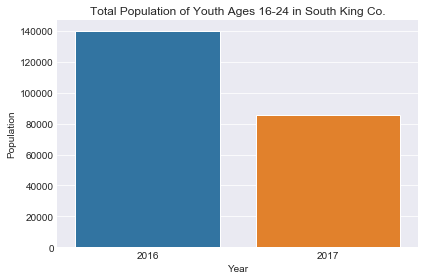

In [250]:
#Plot total youth population in 2016 vs. 2017 - show that population has decreased
sns.barplot(x = 'year',
            y = 'total_population',
            data = youth_population_totals_2016_2017)
plt.title('Total Population of Youth Ages 16-24 in South King Co.')
plt.ylabel('Population')
plt.xlabel('Year')
plt.tight_layout()
plt.savefig("totalpop.png");

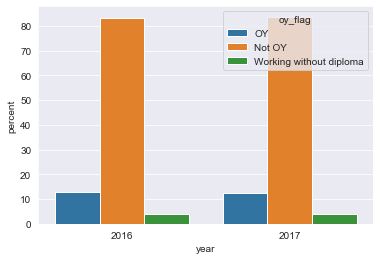

In [232]:
#Plot percent OY population in 2016 vs. 2017 - show that even though population has decreased, the proportion of
#OY youth has also decreased slightly -- figure out how to get only OY
sns.barplot(x = 'year',
            y = 'percent',
            hue = 'oy_flag',
            data = youth_population_totals_2016_2017);

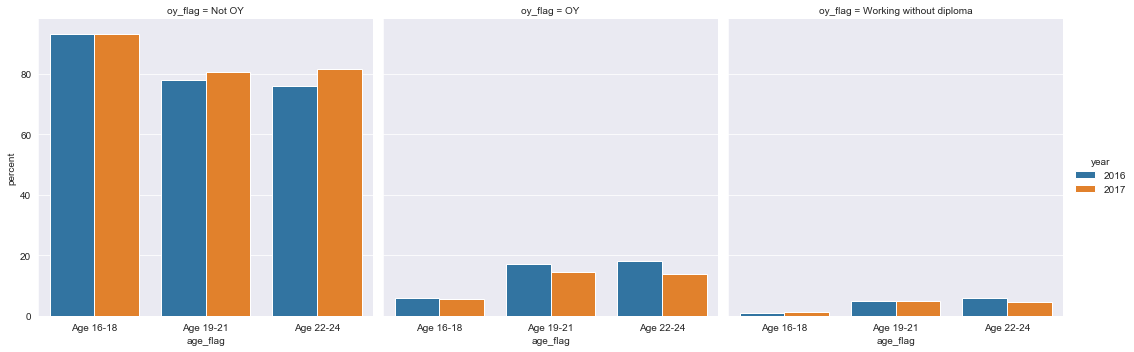

In [231]:
sns.catplot(x = 'age_flag', 
                 y = 'percent',
                 hue = 'year',
                 col = 'oy_flag',
                 kind = 'bar',
                 data = youth_population_2016_2017);

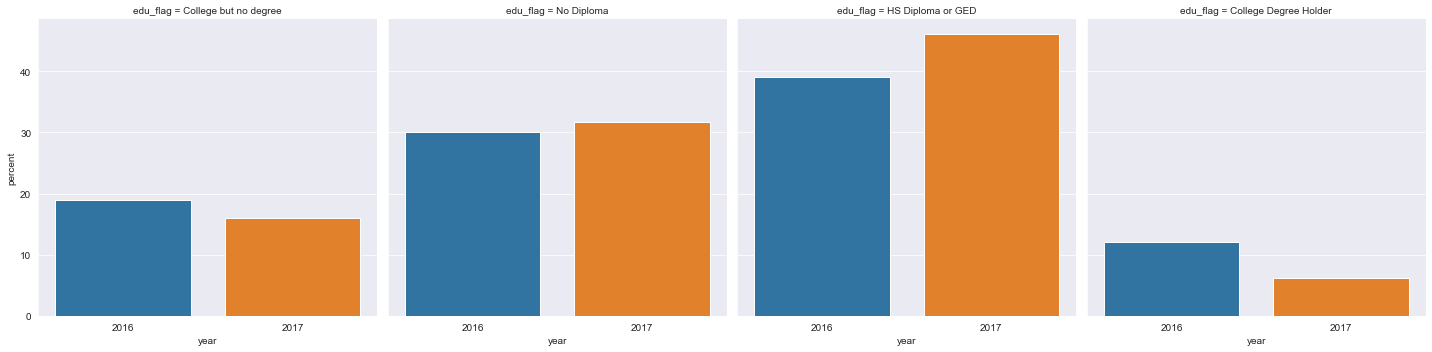

In [240]:
sns.catplot(x = 'year', 
            y = 'percent',
            col = 'edu_flag',
            kind = 'bar',
            data = oy_population_totals_2016_2017);
#plt.title('Proportion of Education Levels for Opportunity Youth');

In [ ]:
#make bar graph showing drop in OY who have college degrees